In [160]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
# nltk.download()

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)

In [161]:
wine = pd.read_csv('redwine.csv', delimiter=';')
chemColNames = ['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']
chem = wine[chemColNames]

colErrorPairs = {
    'density'    : [' . '],
    'citric acid': [' - ',' -   '],
    'alcohol'    : ['100.333.333.333.333','11.066.666.666.666.600','956.666.666.666.667','923.333.333.333.333']}

for colName in colErrorPairs:
    for faultyString in colErrorPairs[colName]:
        wine[colName] = wine[colName].replace(faultyString,np.nan)
        
wine['alcohol'] = wine['alcohol'].astype(float)
wine['density'] = wine['density'].astype(float)
wine['citric acid'] = wine['citric acid'].astype(float)

wineZscore = wine.copy()

for col in chemColNames:
        wineZscore[col] = (wine[col] - wine[col].mean())/wine[col].std(ddof=0)

# Onderzoeksvraag 3: Kun je op basis van bepaalde keywords in de beschrijving een voorspelling doen over hoe hoog de score van deze wijn is? (Supervised - Regression/ Datavisualisatie)

We willen onderzoeken of je de score van de wijn kunt bepalen aan de hand van sommige keywords die gevonden zijn in de titels en de beschrijving.

In [162]:
wine[['title','description']]

,title,description
0,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth..."
1,Casa Santa Vitória 2013 Grande Reserva Tinto R...,"From an estate in the south of the Alentejo, t..."
2,Adega Cooperativa de Borba 2012 Montes Claros ...,A year in wood and 30 months in bottle before ...
3,Quinta de Foz de Arouce 2013 Red (Beira Atlant...,Wood aging gives this ripe blend of Baga and T...
4,Herdade Grande 2010 Gerações Colheita Seleccio...,"A powerful wine, richly structured and full of..."
...,...,...
2460,Quinta de Lemos 2010 Dona Georgina Red (Dão),"Two classic Dão grapes, Touriga Nacional and T..."
2461,Casca Wines 2011 Monte Cascas Grande Reserva R...,Old vines in a field blend give a rich structu...
2462,Quinta da Pacheca 2013 Pacheca Superior Red (D...,This rich wine has a firm structure as well as...
2463,Seacampo 2011 Reserva Red (Dão),This mature wine that has 50% Touriga Nacional...


In [163]:
wordsPerWine = wine[['title','description']]
allWordsSeperated = np.array(' '.join(wordsPerWine.to_numpy().flatten()).replace(',','').split(" "))

In [164]:
allWordsSeperated = np.char.lower(allWordsSeperated)
(allWordsSeperated[:20],'Amount of words',allWordsSeperated.shape)

(array(['quinta', 'dos', 'avidagos', '2011', 'avidagos', 'red', '(douro)',
        'this', 'is', 'ripe', 'and', 'fruity', 'a', 'wine', 'that', 'is',
        'smooth', 'while', 'still', 'structured'], dtype='<U29'),
 'Amount of words',
 (118188,))

In [165]:
unique, counts = np.array(np.unique(allWordsSeperated, return_counts=True))
wordCount = np.array([np.array(unique), np.array(counts)])
wordFrame = pd.DataFrame(wordCount[0],wordCount[1]).reset_index()
wordFrame.columns = ['count','word']

In [166]:
stop_words = set(stopwords.words('english'))
stop_words.update(['wine','red','da','de'])

wordFrame['count'] = wordFrame['count'].astype(int)
print(f'Total of unique seperated words: {wordFrame.shape[0]}')
print(wordFrame['count'])
wordFrame.drop(wordFrame[ (wordFrame['word'].isin(stop_words)) | (wordFrame['count'] < 400)].index , inplace=True)
print(f'Total of unique seperated words with atleast a count of 400 & not a stopword: {wordFrame.shape[0]}')
wordFrame.sort_values(by=['count'], ascending=False).reset_index(drop=True)[:30]

Total of unique seperated words: 4524
0         9
1       156
2         3
3         1
4         1
       ... 
4519      1
4520      1
4521      1
4522      2
4523      1
Name: count, Length: 4524, dtype: int32
Total of unique seperated words with atleast a count of 400 & not a stopword: 28


,count,word
0,1719,tannins
1,1636,drink
2,1303,fruits
3,1170,acidity
4,1111,ripe
5,972,fruit
6,951,black
7,880,(douro)
8,858,rich
9,794,quinta


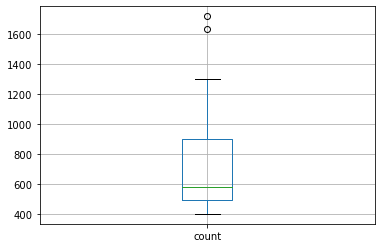

In [167]:
wordFrame.boxplot(column='count')

In [168]:
# Make a new column where we put a count of how many keywords are in the description and or title
wine['keyword_count'] = wine['description'].str.count('|'.join(wordFrame['word'].to_list()))
wine[['points', 'keyword_count','title','description']]

,points,keyword_count,title,description
0,87,10,Quinta dos Avidagos 2011 Avidagos Red (Douro),"This is ripe and fruity, a wine that is smooth..."
1,91,11,Casa Santa Vitória 2013 Grande Reserva Tinto R...,"From an estate in the south of the Alentejo, t..."
2,90,6,Adega Cooperativa de Borba 2012 Montes Claros ...,A year in wood and 30 months in bottle before ...
3,90,10,Quinta de Foz de Arouce 2013 Red (Beira Atlant...,Wood aging gives this ripe blend of Baga and T...
4,92,14,Herdade Grande 2010 Gerações Colheita Seleccio...,"A powerful wine, richly structured and full of..."
...,...,...,...,...
2460,93,10,Quinta de Lemos 2010 Dona Georgina Red (Dão),"Two classic Dão grapes, Touriga Nacional and T..."
2461,93,13,Casca Wines 2011 Monte Cascas Grande Reserva R...,Old vines in a field blend give a rich structu...
2462,90,8,Quinta da Pacheca 2013 Pacheca Superior Red (D...,This rich wine has a firm structure as well as...
2463,90,7,Seacampo 2011 Reserva Red (Dão),This mature wine that has 50% Touriga Nacional...


In [169]:
wine[wine['points'].isnull()]


,id,country,description,designation,points,price,province,taster_name,title,variety,winery,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,keyword_count


In [191]:
features = ['keyword_count','price']

# Feature waardes
X = wine[features]
# Target waardes
y = wine['points']

print(X.shape, y.shape)
# X = X.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

(2465, 2) (2465,)


In [192]:
# slope, intercept, r_value, p_value, std_err = stats.linregress(X,y)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 2465

In [193]:
# slope, intercept, r_value, p_value, std_err

(0.2933403348846344,
 86.60113182969076,
 0.2278392242139714,
 2.163782596036695e-30,
 0.02526013714660693)

In [177]:
# "r-squared:", r_value**2

('r-squared:', 0.05191071209042433)